In [24]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf

In [25]:
import statsmodels.api as sm
from statsmodels.tsa.ardl import *
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import *

In [26]:
df = yf.download('AMZN', start='2010-01-01', end='2020-12-01')
df.shape
df.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000  \
2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                ...         ...         ...         ...         ...   
2020-11-23  155.835007  156.987503  153.272995  154.919495  154.919495   
2020-11-24  155.024994  156.712494  154.313004  155.903000  155.903000   
2020-11-25  157.093506  159.899994  157.013000  159.253494  159.253494   
2020-11-27  160.563004  160.809494  159.502502  159.766998  159.766998   
2020-11-30  160.423996  161.419495  156.277496  158.401993  158.401993   

       

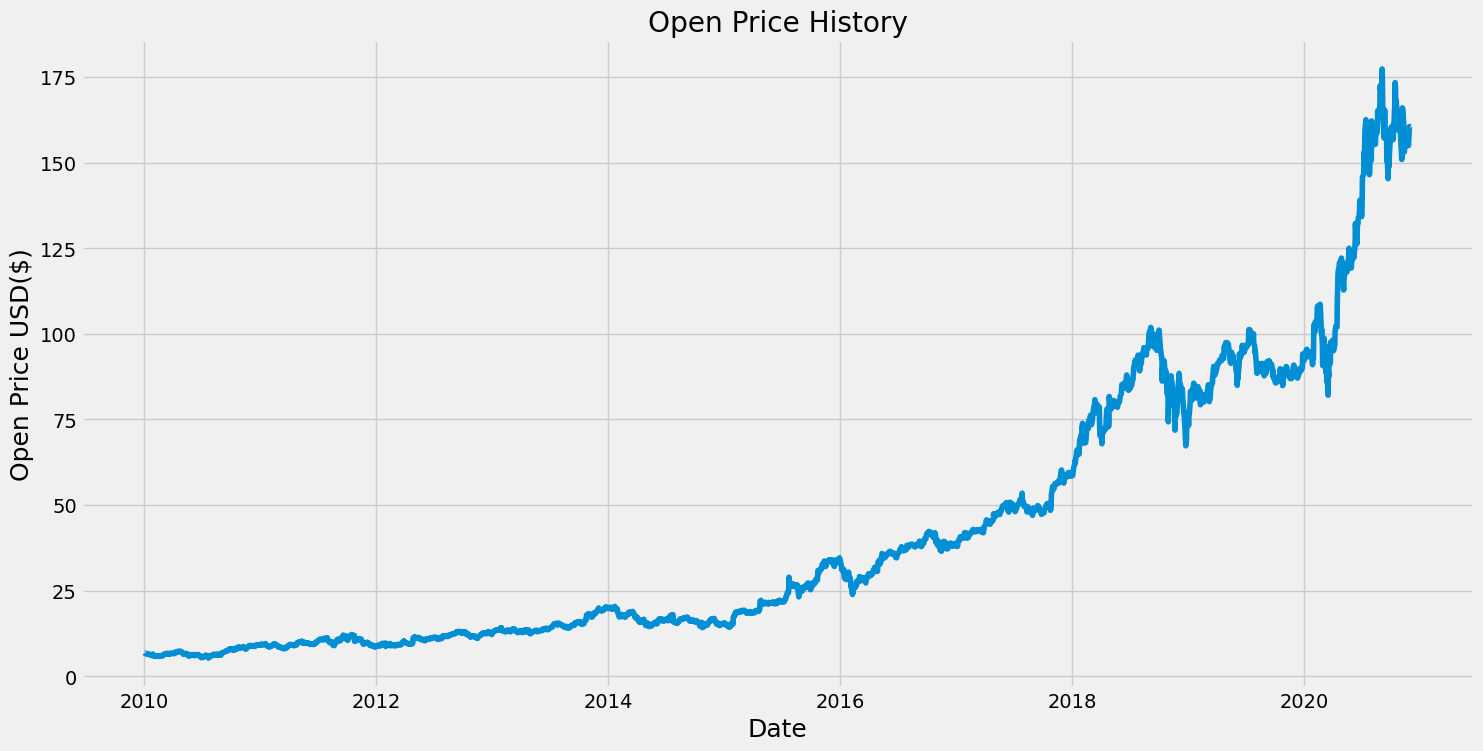

In [27]:

plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Open Price USD($)', fontsize = 18)
plt.show()

In [28]:
# Check for stationarity using Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['Close'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: 2.763113635613827
p-value: 1.0


In [29]:
# Assuming Close needs to be differenced
df['Close_diff'] = df['Close'].diff().dropna()

In [30]:
# Re-run ADF test on differenced data
adf_result_diff = adfuller(df['Close_diff'].dropna())
print('ADF Statistic (differenced):', adf_result_diff[0])
print('p-value (differenced):', adf_result_diff[1])

ADF Statistic (differenced): -11.092611782153014
p-value (differenced): 4.0467113592861083e-20


In [36]:
# Ensure the Date column is used as the index and is a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Optionally, set a frequency (this is crucial for time series models)
df = df.asfreq('B')  # 'B' stands for business day frequency, adjust as needed

In [37]:
# Construct the ARDL model
# Selecting lag=3 for dependent variable, and lag=1 for independent variables as an example
model = ARDL(df['Close_diff'].dropna(), lags=3, exog=df[['Open', 'High']].iloc[1:])
ardl_fit = model.fit()

MissingDataError: exog contains inf or nans

In [32]:

print(ardl_fit.summary())

                              ARDL Model Results                              
Dep. Variable:             Close_diff   No. Observations:                 2746
Model:                  ARDL(3, 0, 0)   Log Likelihood               -4031.793
Method:               Conditional MLE   S.D. of innovations              1.052
Date:                Tue, 20 Aug 2024   AIC                           8077.587
Time:                        01:53:29   BIC                           8119.004
Sample:                             3   HQIC                          8092.552
                                 2746                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0349      0.029      1.187      0.235      -0.023       0.092
Close_diff.L1    -0.0162      0.017     -0.970      0.332      -0.049       0.017
Close_diff.L2     0.0321      0.017     

In [33]:
# Forecasting using the fitted model
# Note: Adjust start and end based on your dataset
forecast_start = len(df) - 50
forecast_end = len(df) - 1
predictions = ardl_fit.predict(start=forecast_start, end=forecast_end, exog_oos=df[['Open', 'High']].iloc[forecast_start+1:forecast_end+1])

C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [34]:
# Prepare actual vs predicted data for plotting
actual_data = df['Close'].iloc[forecast_start+1:forecast_end+1]
predicted_data = predictions + df['Close'].shift(1).iloc[forecast_start+1:forecast_end+1]

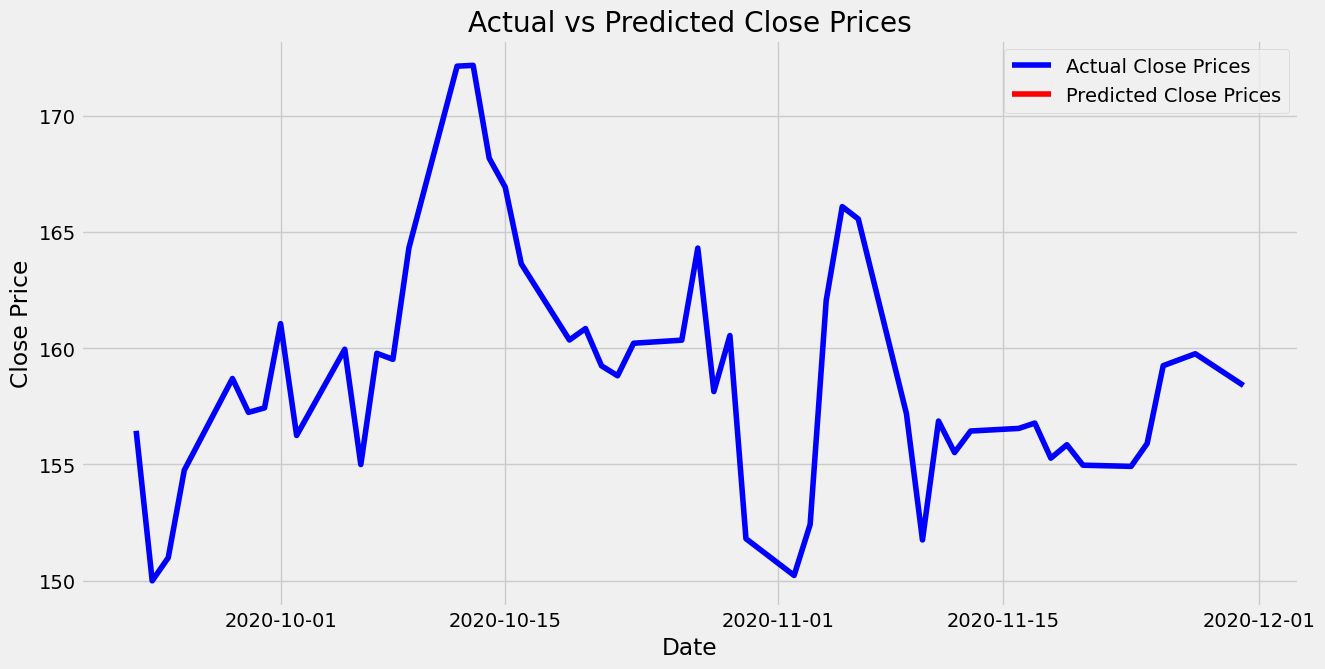

In [35]:
# Plotting the Actual vs Predicted data
plt.figure(figsize=(14, 7))
plt.plot(actual_data.index, actual_data, label='Actual Close Prices', color='blue')
plt.plot(predicted_data.index, predicted_data, label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\athar\AppData\Local\Temp\ipykernel_13452\1983868571.py:2: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  residuals = actual_data - predicted_data


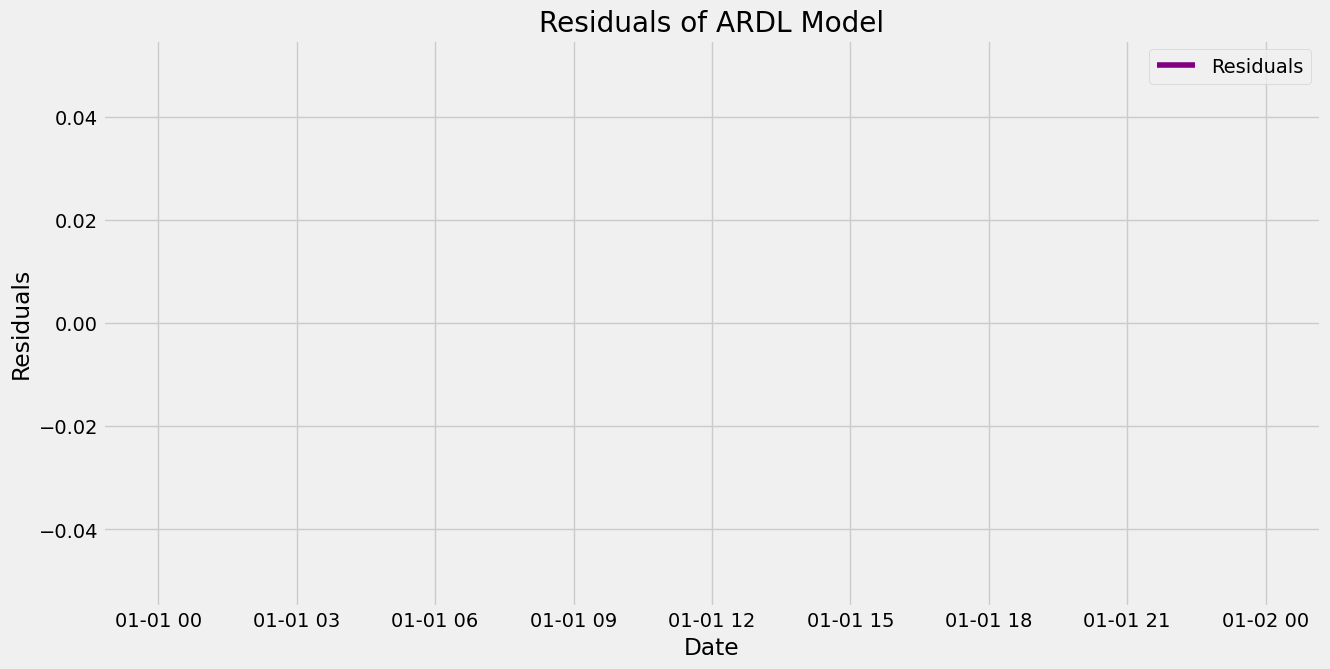

In [22]:
# Plotting the Residuals
residuals = actual_data - predicted_data
plt.figure(figsize=(14, 7))
plt.plot(residuals.index, residuals, label='Residuals', color='purple')
plt.title('Residuals of ARDL Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\stattools.py:472: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
C:\Users\athar\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: negative dimensions are not allowed

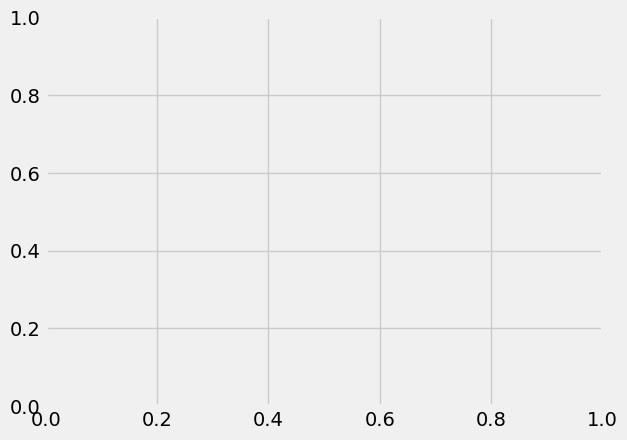

In [23]:
# Plotting ACF of Residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()